# Visualizing COVID-19 Data at the State and County Levels in Python

## Part III: Building Maps in _geopandas_

Now that we have downloaded the COVID-19 data and normalized cases and deaths by population, we can generate maps that allow us to compare values between counties. Just as with the visualizations from the last post,  were we to simply plot the total number of cases or deaths by county, the results would be biased as counties with larger populations would likely have more cases and more deaths. Unlike in the previous post, we will not compare counties by using a common anchor to compare spread (i.e., days since cases per million or deaths per million exceeded some value). Instead, we will see how the spread developed across the country, starting in the northeast, eventually making its way to other regions.

Make sure that you have completed the [previous lesson](https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/blob/master/Projects/COVID19/Visualizing%20COVID-19%20Data%20at%20the%20State%20and%20County%20Levels%20in%20Python%20-%20Parts%20I%20%26%20II.ipynb) before you continue. You will need to download the appropriate shape file - available in this github repository or at the U.S. Census [website](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html). If you'd like, you can continue building from the previous script. I've included only what is necessary, having dropped the dataframe that aggregated county data at the state level. I have also removed the *zero_day_dict*, since we will not be comparing the state of the spread in light of a common anchor.

In [1]:
#createCOVID19StateAndCountyVisualization.py
import geopandas
import numpy as np
import pandas as pd
# We won't actually use datetime directly. Since the dataframe index will use 
# data formatted as datetime64, I import it in case I need to use the datetime
# module to troubleshoot later 
import datetime
# you could technically call many of the submodules from matplotlib using mpl., 
#but for convenience we explicitly import submodules. These will be used for 
# constructing visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick
import datadotworld as dw


def import_geo_data(filename, index_col = "Date", FIPS_name = "FIPS"):
    # import county level shapefile
    map_data = geopandas.read_file(filename = filename,                                   
                                   index_col = index_col)
    # rename fips code to match variable name in COVID-19 data
    map_data.rename(columns={"State":"state"},
                    inplace = True)
    # Combine statefips and county fips to create a single fips value
    # that identifies each particular county without referencing the 
    # state separately
    map_data[FIPS_name] = map_data["STATEFP"].astype(str) + \
        map_data["COUNTYFP"].astype(str)
    map_data[FIPS_name] = map_data[FIPS_name].astype(np.int64)
    # set FIPS as index
    map_data.set_index(FIPS_name, inplace=True)
    
    return map_data

def import_covid_data(filename, FIPS_name):
    # Load COVID19 county data using datadotworld API
    # Data provided by Johns Hopkins, file provided by Associated Press
    dataset = dw.load_dataset("associatedpress/johns-hopkins-coronavirus-case-tracker",
                              auto_update = True)
    # the dataset includes multiple dataframes. We will only use #2
    covid_data = dataset.dataframes["2_cases_and_deaths_by_county_timeseries"]
    # Include only oberservation for political entities within states
    # i.e., not territories, etc... drop any nan fip values with covid_data[FIPS_name] > 0
    covid_data = covid_data[covid_data[FIPS_name] < 57000]
    covid_data = covid_data[covid_data[FIPS_name] > 0]

    # Transform FIPS codes into integers (not floats)
    covid_data[FIPS_name] = covid_data[FIPS_name].astype(int)
    covid_data['date'] = pd.to_datetime(covid_data['date'])
    covid_data.set_index([FIPS_name, "date"], inplace = True)
    # Prepare a column for state abbreviations. We will draw these from a
    # dictionary created in the next step.
    covid_data["state_abr"] = ""
    for state, abr in state_dict.items():
        covid_data.loc[covid_data["state"] == state, "state_abr"] = abr
    # Create "Location" which concatenates county name and state abbreviation 
    covid_data["Location"] = covid_data["location_name"] + ", " + \
        covid_data["state_abr"]

    return covid_data

def create_merged_geo_dataframe(data, map_data, dates):
    data_frame_initialized = False
    # use groupby to generate a df with only the fips_code index
    # then save that index as the variable counties
    counties =data.groupby("fips_code").mean().index
    for date in dates:
        # select county observations from each date in dates
        # select only the subset of counties in the map that
        # are also present in the covid_data
        agg_df = map_data[map_data.index.isin(counties)]
        agg_df["date"] = date
        if data_frame_initialized == False:
            #Create new dataframe
            matching_gpd = geopandas.GeoDataFrame(agg_df, crs = map_data.crs)
            data_frame_initialized = True        
        
        else:
            # or stack thenew  data frame and the dataframe that was initialized at
            # i = 0
            matching_gpd = matching_gpd.append(agg_df, ignore_index = False)
    # reset index, then set to [fips, date]
    matching_gpd.reset_index(inplace=True)
    matching_gpd.set_index(["fips_code", "date"], inplace = True)
    
    for key, val in data.items():
        matching_gpd[key] = val
    return matching_gpd

def create_new_vars(covid_data, moving_average_days):
    # use a for loop that performs the same operations on data for cases and for deaths
    for key in ["cases", "deaths"]:
        # create a version of the key with the first letter capitalized
        cap_key = key.title()
        covid_data.rename(columns={"cumulative_" + key :"Total " + cap_key}, 
                  inplace = True)
        covid_data[cap_key + " per Million"] = covid_data["Total " + cap_key].fillna(0)\
            .div(covid_data["total_population"]).mul(10 ** 6)
        # generate daily data normalized per million population by taking the daily difference within each
        # entity (covid_data.index.names[0]), dividing this value by population and multiplying that value
        # by 1 million 10 ** 6
        covid_data["Daily " + cap_key] = covid_data["new_" + key ]#.groupby(covid_data.index.names[1])\
            #.diff(1)
        covid_data["Daily " + cap_key + " " + str(moving_average_days) + " Day MA"] = covid_data[
            "new_" + key + "_7_day_rolling_avg"]#.rolling(moving_average_days).mean()           
                                   
        # taking the rolling average; choice of number of days is passed as moving_average_days
        covid_data["Daily " + cap_key + " per Million " + str(moving_average_days) + " Day MA"] = \
            covid_data["Daily " + cap_key + " " + str(moving_average_days) + " Day MA"]\
            .div(covid_data["total_population"]).mul(10 ** 6)


In [2]:
# I include this dictionary to convenienlty cross reference state names and
# state abbreviations.
state_dict = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ',
    'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 
    'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 
    'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA','Kansas': 'KS', 'Kentucky': 'KY',
    'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI',
    'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX',
    'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'}

plt.rcParams['axes.ymargin'] = 0
plt.rcParams['axes.xmargin'] = 0
plt.rcParams.update({'font.size': 32})

#if "data_processed" not in locals():
fips_name = "fips_code"
covid_filename = "COVID19DataAP.csv"
# rename_FIPS matches map_data FIPS with COVID19 FIPS name
map_data = import_geo_data(filename = "countiesWithStatesAndPopulation.shp",
                index_col = "Date", FIPS_name= fips_name)
covid_data = import_covid_data(filename = covid_filename, FIPS_name = fips_name)
# dates will be used to create a geopandas DataFrame with multiindex 
dates = sorted(list(set(covid_data.index.get_level_values("date"))))
covid_data = create_merged_geo_dataframe(covid_data, map_data, dates)

C:\Users\JLCat\AppData\Roaming\Python\Python38\site-packages\datadotworld\models\dataset.py:206: UserWarning: Unable to set data frame dtypes automatically using 2_cases_and_deaths_by_county_timeseries schema. Data types may need to be adjusted manually. Error: Integer column has NA values in column 2
  warnings.warn(


In [3]:
covid_data.keys()

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'NAME', 'LSAD', 'ALAND',
       'AWATER', 'Population', 'state', 'geometry', 'uid', 'location_type',
       'location_name', 'total_population', 'cumulative_cases',
       'cumulative_cases_per_100_000', 'cumulative_deaths',
       'cumulative_deaths_per_100_000', 'new_cases', 'new_deaths',
       'new_cases_per_100_000', 'new_deaths_per_100_000',
       'new_cases_7_day_rolling_avg', 'new_deaths_7_day_rolling_avg',
       'state_abr', 'Location'],
      dtype='object')

In [4]:
moving_average_days = 7
create_new_vars(covid_data, moving_average_days)
start_date = "03-15-2020"     
end_date = dates[-1]
# once data is processed, it is saved in the memory
# the if statement at the top of this block of code instructs the computer
# not to repeat these operations 


Next we will create a map showing the state of the spread at the latest date. The process for this is simple. We call data whose index is the latest date and use the _.plot()_ method from the _geopandas_ dataframe. The tricky part will be to use a for loop to plot different kinds of data - levels and rates - since each of these categories will required different features.

To start, we need to select data from counties  within the 48 states, otherwise Alaska and Hawaii will be included, making the representation of the 48 states much smaller. The measures that are slected are rough estimates, but all that matters is that the 48 states reside within the boundaries chosen. Similar to the *data_processed* variable, I include a *map_bounded* variable so that this computation will not be repeated when the script is run multiple times.

In [5]:
def select_data_within_bounds(data, minx, miny, maxx, maxy):
    data = data[data.bounds["maxx"] <= maxx]
    data = data[data.bounds["maxy"] <= maxy]
    data = data[data.bounds["minx"] >= minx]
    data = data[data.bounds["miny"] >= miny]
    
    return data

date = dates[-1]

if "map_bounded" not in locals():
    minx = covid_data[covid_data.index.get_level_values("date")== date].bounds["minx"].min()
    miny = covid_data[covid_data.index.get_level_values("date")== date].bounds["miny"].min()
    maxx = -58
    maxy = covid_data[covid_data.index.get_level_values("date")== date].bounds["maxy"].max()
    # find counties using only 1 date, only performs operation once instead of 
    # several hundred times
    bounded_data =  select_data_within_bounds(covid_data[covid_data.index.get_level_values("date")== date], minx, miny, maxx, maxy)
    counties = bounded_data.groupby("fips_code").mean().index
    covid_map_data =covid_data[covid_data.index.get_level_values("fips_code").isin(counties)]
    map_bounded = True


Next, let's test out the plot function for _geopandas_.

In [6]:
%matplotlib inline
covid_map_data.fillna(0, inplace = True)
covid_map_data

C:\Users\JLCat\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,Population,state,...,state_abr,Location,Cases per Million,Daily Cases,Daily Cases 7 Day MA,Daily Cases per Million 7 Day MA,Deaths per Million,Daily Deaths,Daily Deaths 7 Day MA,Daily Deaths per Million 7 Day MA
fips_code,date,,,,,,,,,,,,,,,,,,,,,
21007,2020-01-22,21,007,00516850,0500000US21007,Ballard,06,639387454,69473325,7888.0,Kentucky,...,KY,"Ballard, KY",0.000000,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
21017,2020-01-22,21,017,00516855,0500000US21017,Bourbon,06,750439351,4829777,19788.0,Kentucky,...,KY,"Bourbon, KY",0.000000,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
21031,2020-01-22,21,031,00516862,0500000US21031,Butler,06,1103571974,13943044,12879.0,Kentucky,...,KY,"Butler, KY",0.000000,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
21065,2020-01-22,21,065,00516879,0500000US21065,Estill,06,655509930,6516335,14106.0,Kentucky,...,KY,"Estill, KY",0.000000,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
21069,2020-01-22,21,069,00516881,0500000US21069,Fleming,06,902727151,7182793,14581.0,Kentucky,...,KY,"Fleming, KY",0.000000,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31073,2021-09-14,31,073,00835858,0500000US31073,Gosper,06,1186616237,11831826,1990.0,Nebraska,...,NE,"Gosper, NE",92803.970223,0.0,0.00,0.000000,2481.389578,0.0,0.00,0.000000
39075,2021-09-14,39,075,01074050,0500000US39075,Holmes,06,1094405866,3695230,43960.0,Ohio,...,OH,"Holmes, OH",71137.052828,9.0,13.71,312.592626,2439.636107,4.0,0.57,12.996192
48171,2021-09-14,48,171,01383871,0500000US48171,Gillespie,06,2740719114,9012764,26988.0,Texas,...,TX,"Gillespie, TX",124198.717949,25.0,21.14,806.623932,2480.158730,0.0,0.14,5.341880


<AxesSubplot:>

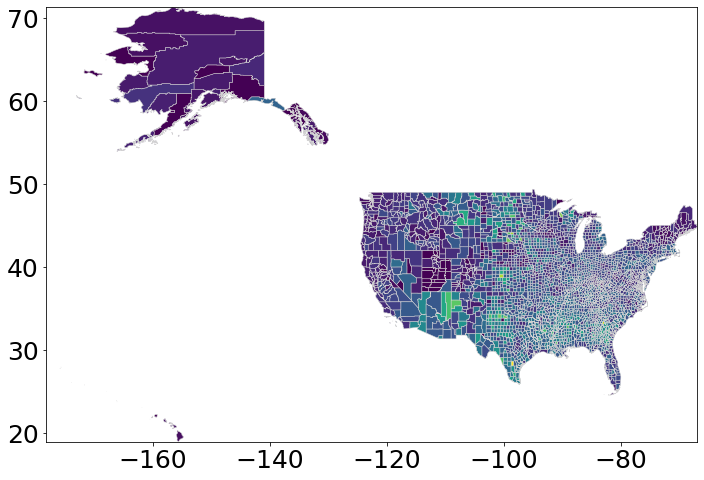

In [7]:
fig, ax = plt.subplots(figsize=(18,8),
        subplot_kw = {'aspect': 'equal'})   
plt.rcParams.update({"font.size": 30})
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
key = "Deaths per Million"
df = covid_map_data[covid_map_data.index.get_level_values("date")== date]
df.plot(ax=ax, cax = ax, column=key, linewidth=.5, 
             edgecolor='lightgrey')

The result looks okay. A few things can be improved. First, it's usually a good idea to select a colormap that spans a narrow range of colors. For this purpose, we will choose to use the colorbar defined by "Reds" in matplotlib. Color choice also conveys affect to the reader. A choice of color, say "Blues", might  strike the viewer as conveying neutral content. Our choice of red conveys that areas that are darker shades of red tend to have been more greatly impacted by the COVID-19. The variable _"Deaths per Million"_ normalizes death by population, allowing for a fair comparison between counties. 

Since we are plotting levels of values, it will be useful to compare logged values. This will give us a sense that some areas are doing better or worse by orders of magnitude, depending on the plot, about 10 to 20 times better or worse given each change in color. To have colors represent a range of logged values, we use the _cm.colors.LogNorm()_ and apply this with _plt.cm.ScalarMappable()_. We explicitly identify min and max values as this will be useful to us when we plot animations over time later in this lesson.

Finally, in the title, we identify the date, region, and the category of data represented.

<ipython-input-8-847b75fe5379>:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


(53.0, 71.0)

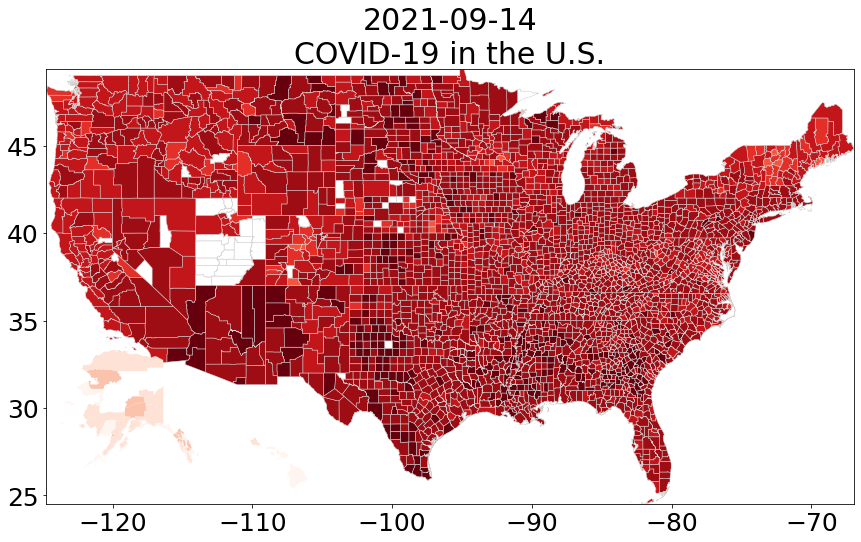

In [8]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
fig, ax = plt.subplots(figsize=(18,8),
        subplot_kw = {'aspect': 'equal'})   
plt.rcParams.update({"font.size": 30})
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
key = "Deaths per Million"
map_data = covid_map_data[covid_map_data.index.get_level_values("date")== date]
df = map_data[~map_data["state"].str.contains("Alaska|Hawaii")]
cmap = cm.get_cmap('Reds', 10)
vmin = 1 
vmax = df[key].max()
norm = cm.colors.LogNorm(vmin=vmin, vmax =vmax)
plt.cm.ScalarMappable(cmap=cmap, norm=norm)
df.plot(ax=ax, cax = ax, column=key, vmin=vmin ,vmax = vmax, 
             cmap = cmap, legend=False, linewidth=.5, edgecolor='lightgrey', 
             norm = norm)
ax.set_title(str(date)[:10] + "\n" + "COVID-19 in the U.S.", fontsize = 30)
axins = {}
axins["Alaska"] = inset_axes(ax, width="17%", height="35%", loc="lower left")
axins["Hawaii"] = inset_axes(ax, width="50%", height="40%", loc="lower left")
for state in axins.keys():
    axins[state].set_xticks([])
    axins[state].set_yticks([])
    axins[state].axis("off")
    map_data[map_data["state"].str.contains(state)].plot(
        ax = axins[state], cax = ax, cmap = cmap, norm = norm)
axins["Hawaii"].set_xlim(-161, -154)
axins["Alaska"].set_ylim(53, 71)


We also want to include a colorbar so that the viewer knows what values are conveyed by map colors. This requires the addition of several parameters that allow for inclusion of a colorbar legend. To construct the colorbar, we need to call *make_axes_locatable(ax)*, then use this to create a colorbar axis, _cax_. Using _cax_ and *cmap*, created in the block of code executed in the previous section, we are able to create a colorbar. To control the value format, we create a list of the axis values, making sure that they are integers (not floats). Then, identify the newly created _matplotlib_ objects in the _.plot()_ method.

Since the color axis is logged, technically it doesn't include a representation for *0*. When passing the dataframe, replace all 0 values with 1 in order to transform the white counties into beige. If you were to use this map, be sure to note that you have made this adjustment.

<ipython-input-9-ee73d5920c22>:27: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
<ipython-input-9-ee73d5920c22>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in vals])


(53.0, 71.0)

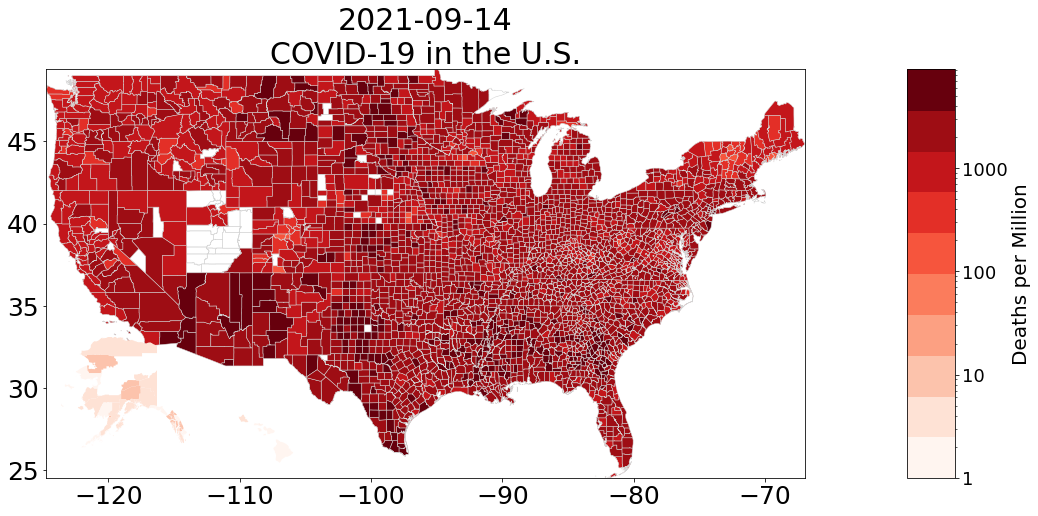

In [9]:
fig, ax = plt.subplots(figsize=(18,8),
        subplot_kw = {'aspect': 'equal'})   
plt.rcParams.update({"font.size": 30})
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
key = "Deaths per Million"
# this time we replace 0 values with 1
# so that these values show up as beige instead of as white
# when color axis is logged
map_data = covid_map_data[covid_map_data.index.get_level_values("date")== date]
df = map_data[~map_data["state"].str.contains("Alaska|Hawaii")]
# set range of colorbar
vmin = 1 
vmax = df[key].max()
# choose colormap
cmap = cm.get_cmap('Reds', 10)
# format colormap
norm = cm.colors.LogNorm(vmin = vmin, vmax = vmax)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# empty array for the data range
sm._A = []
# prepare space for colorbar
divider = make_axes_locatable(ax)
size = "5%" 
cax = divider.append_axes("right", size = size, pad = 0.1)
# add colorbar to figure
cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
cbar.ax.tick_params(labelsize=18)
vals = list(cbar.ax.get_yticks())
vals.append(vmax)
# format colorbar values as int
cbar.ax.set_yticklabels([int(x) for x in vals])
cbar.ax.set_ylabel(key, fontsize = 20)


df.plot(ax=ax, cax = cax, column=key, vmin=vmin ,vmax = vmax, 
             cmap = cmap, legend=False, linewidth=.5, edgecolor='lightgrey', 
             norm = norm)
ax.set_title(str(date)[:10] + "\n" + "COVID-19 in the U.S.", fontsize = 30)
axins = {}
axins["Alaska"] = inset_axes(ax, width="17%", height="33%", loc="lower left")
axins["Hawaii"] = inset_axes(ax, width="50%", height="40%", loc="lower left")
for state in axins.keys():
    axins[state].set_xticks([])
    axins[state].set_yticks([])
    axins[state].axis("off")
    map_data[map_data["state"].str.contains(state)].plot(
        ax = axins[state], cax = ax, cmap = cmap, norm = norm)
axins["Hawaii"].set_xlim(-161, -154)
axins["Alaska"].set_ylim(53, 71)

Congratulations! You've made a quality map. Next, let's use a for loop to create maps for all for categories that we plotted in the previous post. This is simple. First we define a list of keys, and iterate over each key.

<ipython-input-10-6a669d72f738>:34: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
<ipython-input-10-6a669d72f738>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in vals])


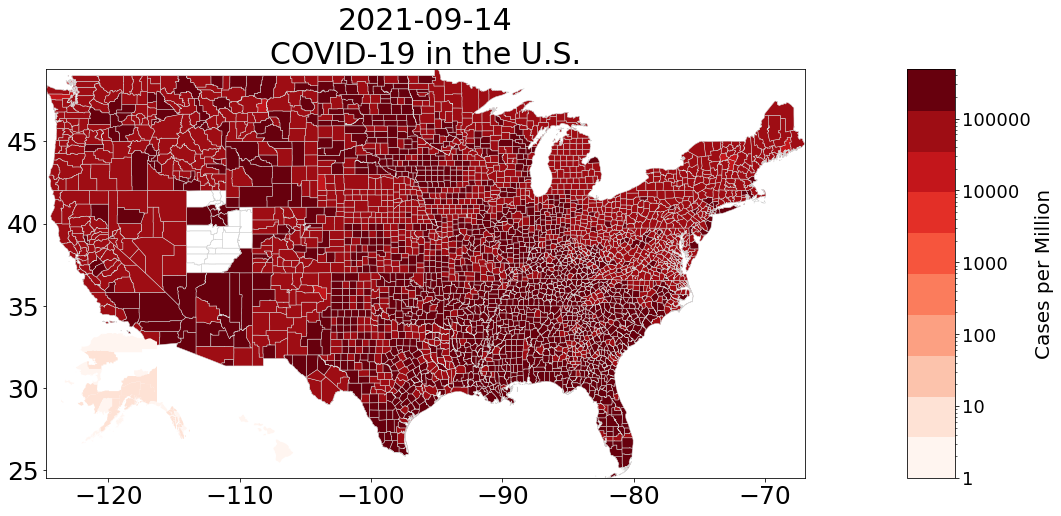

<ipython-input-10-6a669d72f738>:34: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
<ipython-input-10-6a669d72f738>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in vals])


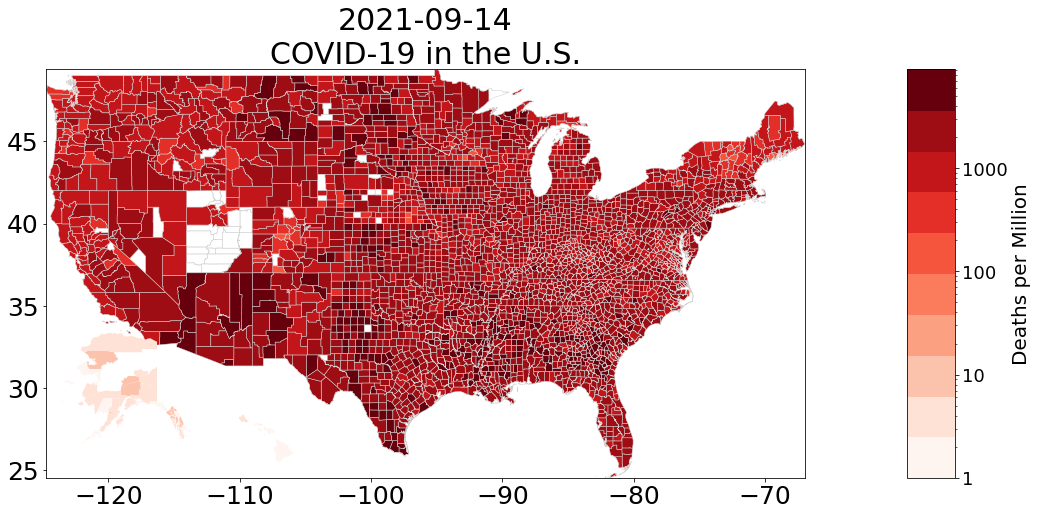

<ipython-input-10-6a669d72f738>:34: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
<ipython-input-10-6a669d72f738>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in vals])


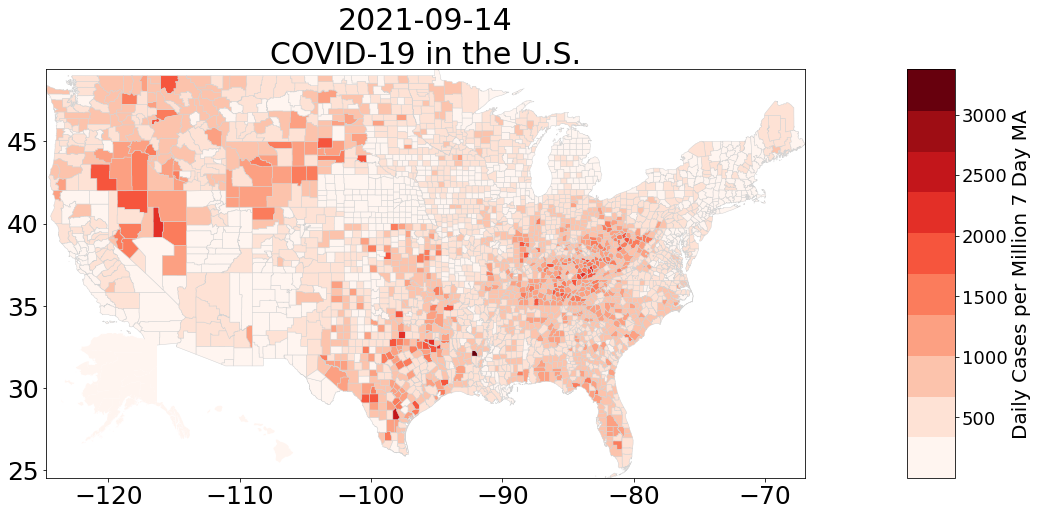

<ipython-input-10-6a669d72f738>:34: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
<ipython-input-10-6a669d72f738>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in vals])


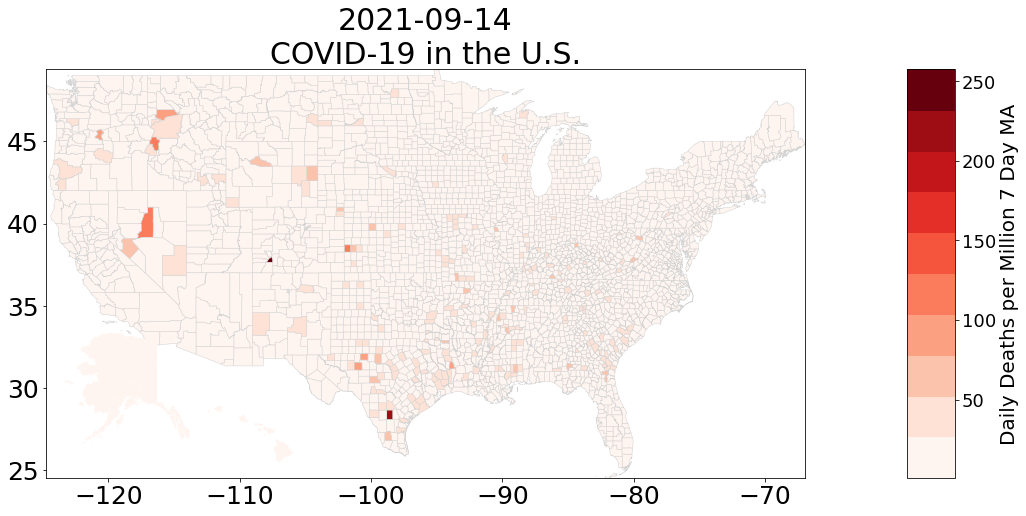

In [10]:
keys = ["Cases per Million", "Deaths per Million", 
        "Daily Cases per Million 7 Day MA", "Daily Deaths per Million 7 Day MA"]
for key in keys:
    fig, ax = plt.subplots(figsize=(18,8),
            subplot_kw = {'aspect': 'equal'})   
    plt.rcParams.update({"font.size": 30})
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    # this time we replace 0 values with 1
    # so that these values show up as beige instead of as white
    # when color axis is logged
    map_data = covid_map_data[covid_map_data.index.get_level_values("date")== date]
    df = map_data[~map_data["state"].str.contains("Alaska|Hawaii")]
    vmin = 1 
    vmax = df[key].max()

    cmap = cm.get_cmap('Reds', 10)
    # only log level values
    if "Daily" not in key:
        norm = cm.colors.LogNorm(vmin=vmin, vmax =vmax)
    # if daily rate, do not log values
    else:
        norm = cm.colors.Normalize(vmin = vmin, vmax = vmax)

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    divider = make_axes_locatable(ax)
    size = "5%" 
    # prepare space for the color bar
    cax = divider.append_axes("right", size = size, pad = 0.1)
    # add colorbar to figure
    cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
    cbar.ax.tick_params(labelsize=18)
    vals = list(cbar.ax.get_yticks())
    vals.append(vmax)
    
    # format colorbar values as int
    cbar.ax.set_yticklabels([int(x) for x in vals])
    cbar.ax.set_ylabel(key, fontsize = 20)

    df.plot(ax=ax, cax = cax, column=key, vmin=vmin ,vmax = vmax, 
                 cmap = cmap, legend=False, linewidth=.5, edgecolor='lightgrey', 
                 norm = norm)
    ax.set_title(str(date)[:10] + "\n" + "COVID-19 in the U.S.", fontsize = 30)
    axins = {}
    axins["Alaska"] = inset_axes(ax, width="17%", height="35%", loc="lower left")
    axins["Hawaii"] = inset_axes(ax, width="50%", height="40%", loc="lower left")
    for state in axins.keys():
        axins[state].set_xticks([])
        axins[state].set_yticks([])
        axins[state].axis("off")
        map_data[map_data["state"].str.contains(state)].plot(
            ax = axins[state], cax = ax, cmap = cmap, norm = norm)
    axins["Hawaii"].set_xlim(-161, -154)
    axins["Alaska"].set_ylim(53, 71)
    
    plt.show()
    plt.close()

### Building an Animated Visualization

Now that you have built a map, it is only a few more steps to creating an animation and [saving as](https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c) an mp4 (or gif or other format that you prefer) that shows how COVID-19 has evolved over time! 

We will be using the _FuncAnimation()_ method from _matplotlib_. This requires that we create to functions: *init()* and *plot_map()*. First we will build a static visualization using these functions, then we will use these functions in combination with _FuncAnimation()_ to create dynamic the evolution of the map over time.

<ipython-input-11-dd7819cc83d4>:26: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
<ipython-input-11-dd7819cc83d4>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in vals])


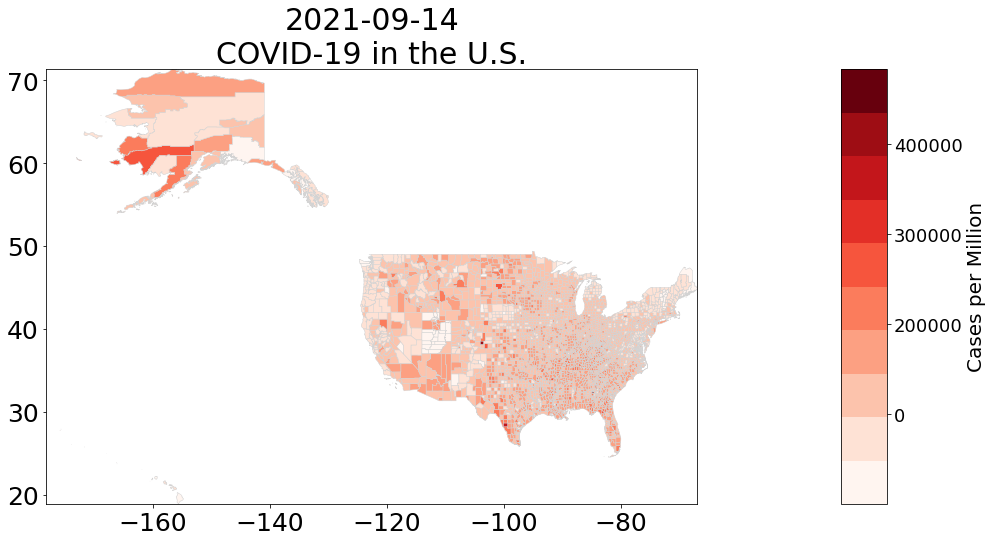

<ipython-input-11-dd7819cc83d4>:26: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
<ipython-input-11-dd7819cc83d4>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in vals])


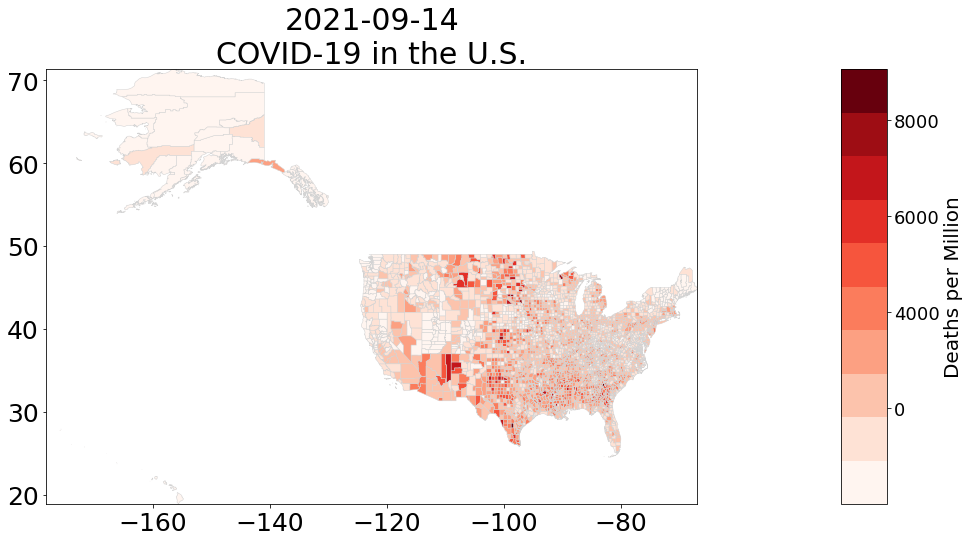

<ipython-input-11-dd7819cc83d4>:26: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
<ipython-input-11-dd7819cc83d4>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in vals])


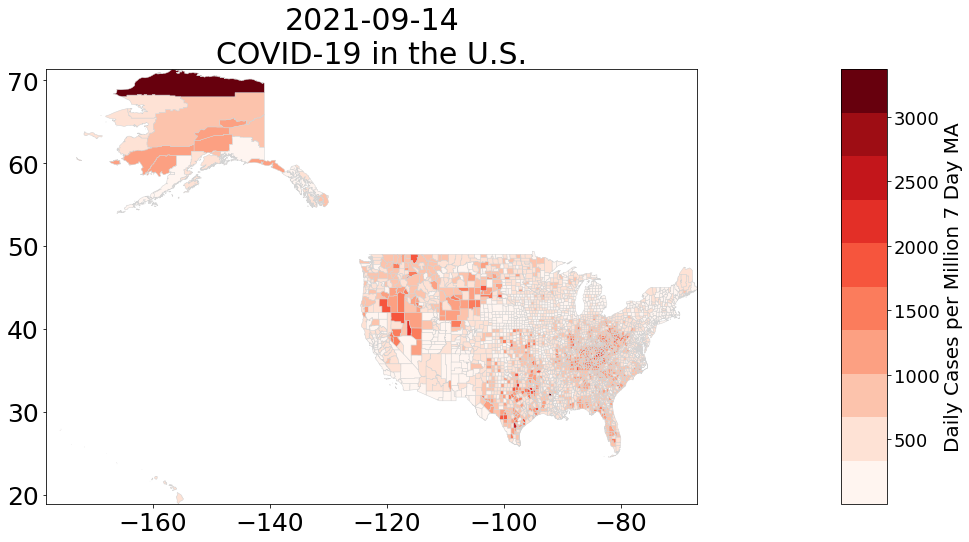

<ipython-input-11-dd7819cc83d4>:26: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
<ipython-input-11-dd7819cc83d4>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in vals])


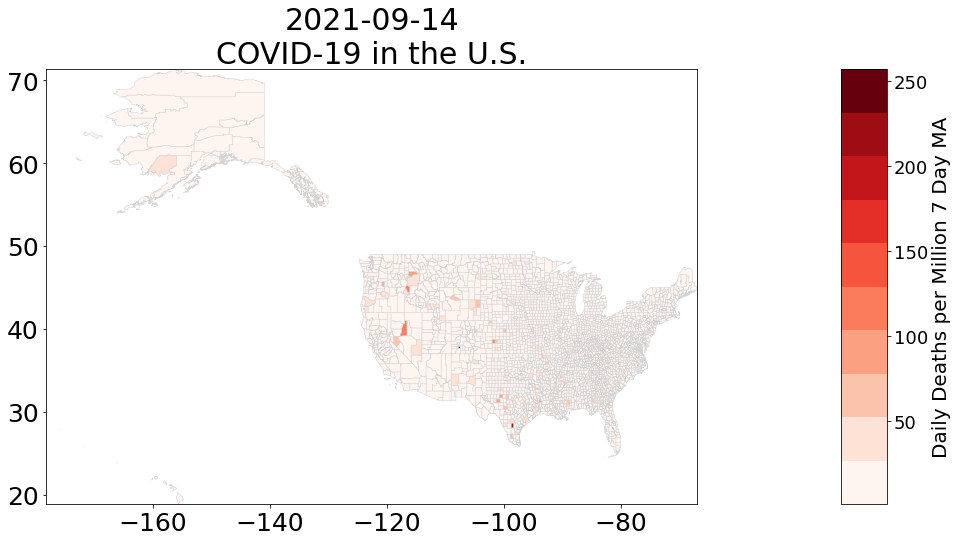

In [11]:
def select_data_within_bounds(data, minx, miny, maxx, maxy):
    data = data[data.bounds["maxx"] <= maxx]
    data = data[data.bounds["maxy"] <= maxy]
    data = data[data.bounds["minx"] >= minx]
    data = data[data.bounds["miny"] >= miny]
    
    return data

def plot_map(*kwargs):
    plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plot_df = df[df.index.get_level_values("date")==date]
    plot_df.plot(ax=ax, cax = ax, column=key, vmin=vmin ,vmax = vmax, 
                 cmap = cmap, legend=False, linewidth=.5, edgecolor='lightgrey', 
                 norm = norm)
    ax.set_title(str(date)[:10] + "\n" + "COVID-19 in the U.S.", fontsize = 30)
    
def init(*kwargs):
    size = "5%"     
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size = size, pad = 0.1)
    # add colorbar to figure
    cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
    cbar.ax.tick_params(labelsize=18)
    vals = list(cbar.ax.get_yticks())
    vals.append(vmax)
    if "Daily" not in key: vals[0] = 0 
    # format colorbar with logged or observed values
    if log:
        cbar.ax.yaxis.set_major_formatter(mtick.LogFormatter())
    else:
        cbar.ax.yaxis.set_major_formatter(mtick.Formatter())
    # format colorbar values as int
    cbar.ax.set_yticklabels([int(x) for x in vals])
    cbar.ax.set_ylabel(key, fontsize = 20)
    
date = dates[-1]
keys = ["Cases per Million", "Deaths per Million", 
        "Daily Cases per Million 7 Day MA", "Daily Deaths per Million 7 Day MA"]

#if "map_bounded" not in locals():
#    minx = -127
#    miny = 23
#    maxx = -58
#    maxy = 54
#    covid_map_data = select_data_within_bounds(covid_data, minx, miny, maxx, maxy)
#    map_bounded = True


for key in keys:
    # log = False if "Daily" in key else True
    log = False
    # this time we replace 0 values with 1
    # so that these values show up as beige  instead of as white
    # when color axis is logged
    df = covid_map_data.replace(0,1)
    vmin= 1
    vmax = df[key][df.index.get_level_values("date") == date].max()
    # Create colorbar as a legend
    cmap = cm.get_cmap('Reds', 10)
    if log:
        norm = cm.colors.LogNorm(vmin=vmin, vmax =vmax)
    else:
        norm = cm.colors.Normalize(vmin = vmin, vmax = vmax)

    fig, ax = plt.subplots(figsize=(18,8),
        subplot_kw = {'aspect': 'equal'})   
    plt.rcParams.update({"font.size": 30})
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    # the functions will unpack the tuple. The same names variable names
    # are used in the function
    kwargs = (df, key, log, date, fig, ax, cmap, norm, vmin, vmax)
    init(kwargs)
    plot_map(kwargs)
    
    plt.show()    

    plt.close()

The final step is to use FuncAnimation to show the evolution of the virus over time.

In [12]:
# . . . 
# list dates starting in mid-march
dates = sorted(list(set(covid_data.index.get_level_values("date"))))
dates = dates[(len(dates) - 55) * -1 - 1   ::3]

[Timestamp('2020-03-16 00:00:00'), Timestamp('2020-03-19 00:00:00'), Timestamp('2020-03-22 00:00:00'), Timestamp('2020-03-25 00:00:00'), Timestamp('2020-03-28 00:00:00'), Timestamp('2020-03-31 00:00:00'), Timestamp('2020-04-03 00:00:00'), Timestamp('2020-04-06 00:00:00'), Timestamp('2020-04-09 00:00:00'), Timestamp('2020-04-12 00:00:00'), Timestamp('2020-04-15 00:00:00'), Timestamp('2020-04-18 00:00:00'), Timestamp('2020-04-21 00:00:00'), Timestamp('2020-04-24 00:00:00'), Timestamp('2020-04-27 00:00:00'), Timestamp('2020-04-30 00:00:00'), Timestamp('2020-05-03 00:00:00'), Timestamp('2020-05-06 00:00:00'), Timestamp('2020-05-09 00:00:00'), Timestamp('2020-05-12 00:00:00'), Timestamp('2020-05-15 00:00:00'), Timestamp('2020-05-18 00:00:00'), Timestamp('2020-05-21 00:00:00'), Timestamp('2020-05-24 00:00:00'), Timestamp('2020-05-27 00:00:00'), Timestamp('2020-05-30 00:00:00'), Timestamp('2020-06-02 00:00:00'), Timestamp('2020-06-05 00:00:00'), Timestamp('2020-06-08 00:00:00'), Timestamp('20

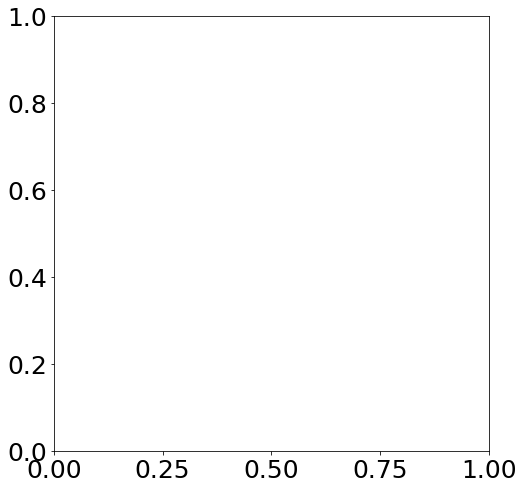

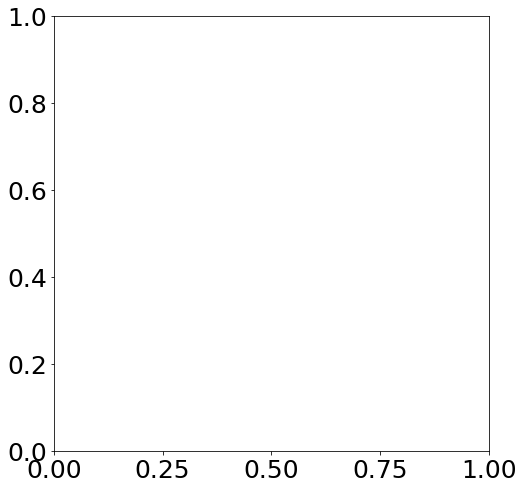

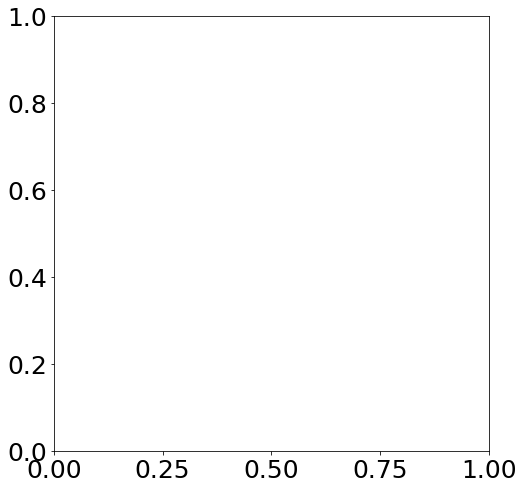

In [13]:
def plot_map(date, *kwargs):
    # For each frame, clear old content
    ax.clear()
    # the FuncAnimation cycles from 0 to i frames,
    # use the i value for your dates
    plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plot_df = df[df.index.get_level_values("date")==date]
    plot_df[~plot_df["state"].str.contains(
                    "Alaska|Hawaii")].plot(ax=ax, cax = ax, column=key,
                 cmap = cmap, legend=False, linewidth=.5, edgecolor='lightgrey', 
                 norm = norm)

    axins = {}
    axins["Alaska"] = inset_axes(ax, width="17%", height="35%", loc="lower left")
    axins["Hawaii"] = inset_axes(ax, width="50%", height="40%", loc="lower left")
    for state, axin in axins.items():
        axins[state].set_xticks([])
        axins[state].set_yticks([])
        axins[state].axis("off")
        plot_df[plot_df["state"].str.contains(state)].plot(ax=axins[state], cax = ax, column=key, 
                                                       cmap = cmap, legend=False, 
                                                       linewidth=.5, edgecolor='lightgrey', 
                                                       norm = norm)
    axins["Hawaii"].set_xlim(-161, -154)
    axins["Alaska"].set_ylim(53, 71)

    ax.set_title(str(date)[:10] + "\n" + "COVID-19 in the U.S.", fontsize = 30)
    
def init(*kwargs):
    size = "5%" 
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    # empty array for the data range
    sm._A = []
    # make space for colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size = size, pad = 0.1)
    # add colorbar to figure
    cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
    cbar.ax.tick_params(labelsize=18)
    vals = list(cbar.ax.get_yticks())
    vals.append(vmax)
    #if "Daily" not in key: 
    vals[0] = 0
    # format display of values on colorbar
    if log:
        cbar.ax.yaxis.set_major_formatter(mtick.LogFormatter())
    else:
        cbar.ax.yaxis.set_major_formatter(mtick.Formatter())
    # format colorbar values as int
    cbar.ax.set_yticklabels([int(x) for x in vals])
    cbar.ax.set_ylabel(key, fontsize = 20)
    
keys = [ "Deaths per Million", "Daily Cases per Million 7 Day MA", "Daily Deaths per Million 7 Day MA"]

print(dates)
# create dictionary to hold animations. We will call these in the next cell.
anim_dict = {}
for key in keys:
    log = False #if "Daily" in key else True
    # this time we replace 0 values with 1
    # so that these values show up as beige  instead of as white
    # when color axis is logged
    df = covid_map_data
    vmin= 0
    vmax = df[key].max()
    # Create colorbar as a legend
    cmap = cm.get_cmap('Reds', 10)
    if log:
        norm = cm.colors.LogNorm(vmin=vmin, vmax =vmax)
    else:
        norm = cm.colors.Normalize(vmin = vmin, vmax = vmax)

    fig, ax = plt.subplots(figsize=(18,8),
        subplot_kw = {'aspect': 'equal'})   
    plt.rcParams.update({"font.size": 30})
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    # the functions will unpack the tuple. The same names variable names
    # are used in the function
    kwargs = (df, key, log, fig, ax, cmap, norm, vmin, vmax)
    frames = dates
    #anim = FuncAnimation(fig, plot_map, frames = dates, 
    #                    blit = False, init_func = init, interval=150, 
    #                     fargs = kwargs)
    # Use the next line to save the video as an MP4.
    #anim.save(key + ".mp4", writer = "ffmpeg")
    #plt.close()

You can view the saved videos in the folder holding your python script. While Jupyter allows you to embed videos, Github's frame for loading Jupyter notebooks does not play videos. You can click the links to download the MP4 files for each frame.

[Cases per Million](https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/raw/master/Projects/COVID19/Cases%20per%20Million.mp4)

[Deaths per Million](https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/raw/master/Projects/COVID19/Deaths%20per%20Million.mp4)

[Daily Cases per Million MA](https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/raw/master/Projects/COVID19/Daily%20Cases%20per%20Million%20MA.mp4)

[Daily Deaths per Million MA](https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/raw/master/Projects/COVID19/Daily%20Deaths%20per%20Million%20MA.mp4)

Great work! You have learned how to use _geopandas_ to build maps. Then you learned to use _funcAnimation()_ from _matplotlib_ to create videos. As you have seen, once you are able to build a single map, there is only a bit more work required to create an animation that shows the evolution of geospatial data over time.

If you found this lesson useful, check out [Learn Python for Economic Computation](https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/tree/master/Textbook).

In [14]:
save_data= covid_map_data.copy()

## Save Data

Lastly, we will save the data as a parquet. This will allow us to efficiently reuse the data for other applications.

In [15]:
save_data= save_data[["Total Cases", "Total Deaths",
                      'Cases per Million', "Deaths per Million",
                      "Daily Cases", "Daily Deaths",
                      "Daily Cases " + str(moving_average_days) + " Day MA",
                      "Daily Deaths " + str(moving_average_days) + " Day MA",
                      "Daily Cases per Million 7 Day MA", "Daily Deaths per Million 7 Day MA",
                      "total_population", "state"]]

save_data.to_parquet("../COVID19DataForVoila.parquet.gzip", compression = "gzip",
                    engine = "pyarrow")

%run "buildStateCountyPivot.py"

<Figure size 432x288 with 0 Axes>